## 7. Comparing Simulations and the Model

We now want to be able to plot the models we've derived alongside the numerical results from the black hole simulation. Since the data needs its own code to process and plot, let's just export that data as a Numpy array and load it into this script.

The code at https://github.com/mccbc/thindisk/blob/master/data/plot_spherical.py has been edited to produce an output `.npy` file that contains the radial profile data we will want to plot. This line of code needs to be inserted at Line 291: 
`np.save('exported_data_{}.npy'.format(kwargs['quantity']), np.array([r, vals[0]]))`
You can either make this change yourself, or re-download the script. Once you run it with the terminal command
`python plot_spherical.py -a -m diskmc.out1.00001.athdf tgas test.png`, a data file will be saved called `exported_data_tgas.npy` in the same file directory. 

In [2]:
# Load the data using numpy
import numpy as np
r_data, tgas_data = np.load("/home/connor/Documents/thindisk/data/exported_data_tgas.npy")

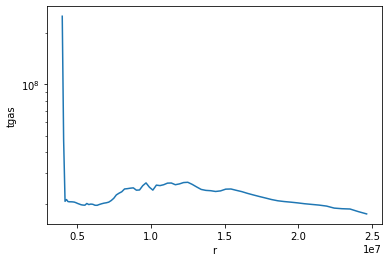

In [3]:
# Plot the data again
import matplotlib.pyplot as plt
plt.plot(r_data, tgas_data)
plt.yscale('log')
plt.xlabel('r')
plt.ylabel('tgas')
plt.show()

Great! Now that we have that data, we can plot both the simulated data and the model together. Remember the code we used to produce the model. We'll try out two different ways of calculating the temperature profile. 

1. Using a function called `Teff`, we'll calculate the effective temperature as just the 4th root of the flux divided by the Stefan-Boltzmann constant. We will plug in our `F(r, M, Mdot, r_in)` function for the flux here.
2. Using the function Trent wrote, we'll calculate the effective temperature the same way, but we'll get rid of the `(1. - np.sqrt(r_in / r)` term in the flux equation. This function will be called `Teff_approx`. This is an approximation we're choosing to make, so we should be prepared to justify it. **For what values of r_in do we expect this approximation to hold?** i.e., what has to be true about `r_in` and `r` to be able to say that `(1. - np.sqrt(r_in / r)` is approximately 1?

In [4]:
import astropy.constants as c
import astropy.units as u

def F(r, M, Mdot, r_in):
    flux = 3. * c.G * M * Mdot / (8. * np.pi * r**3) * (1. - np.sqrt(r_in / r))    # Calculate the flux
    return flux.to(u.Unit("erg/(cm2 s)"))

def Teff(r, M, Mdot, r_in):
    '''
    A simple calculation of the effective temperature that uses the equation T_eff = (F/sigma)**(1/4). 
    Here, we plug in our flux equation for F. This includes information about r_in, the interior radius of the
    accretion disk.
    '''
    return ((F(r, M, Mdot, r_in)/c.sigma_sb)**(1/4)).decompose()

def Teff_approx(r, M, Mdot): 
    '''
    A calculation of the effective temperature that uses the equation T_eff = (F/sigma)**(1/4), where we have 
    plugged in F = 3 * G * M * Mdot / (8 * pi * r**3) for the flux, approximating out the dependence on r_in.
    This calculation should be correct when r (?????) r_in.
    '''
    numerator = 3 * c.G * M * Mdot
    denominator = 8 * np.pi * c.sigma_sb * (c.G * M / c.c**2)**3
    first_term = (numerator / denominator)**(1/4)
    second_term =(r/gr(M))**(-3/4)
    return (first_term * second_term).decompose() 

def gr(m):
    grav_radius = ((c.G * m) / (c.c**2))
    return grav_radius.to(u.cm)

In [47]:
# This is the mass of the black hole used in the simulation
mass = 6.62*u.solMass

# Here are our guesses for what the accretion rate should be. Change these to get the temperature
# profiles to line up in the outer region of the disk. This is one of our "free variables", so we 
# can use the fit to try to determine what the mass accretion rate is.

accr_rate_approx = 0.0001*u.solMass/u.yr # These aren't right! Change the values to make the fits better.
accr_rate = 0.00025*u.solMass/u.yr # If we increase the accretion rate, what do we expect to happen to the temperature?


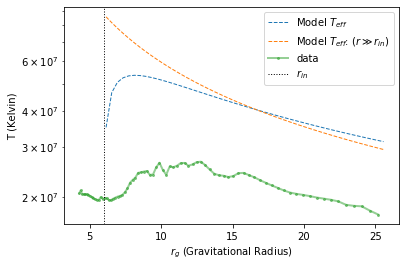

In [58]:
r_model = np.linspace(0.6e7, 2.5e7)*u.cm

tgas_approx = Teff_approx(r_model, mass, accr_rate_approx)
tgas = Teff(r_model, mass, accr_rate, 6*gr(mass)) # Remember that r_in should be about 3 graviational radii

# Plot the model lines
plt.plot(r_model/gr(mass), tgas, '--', label='Model $T_{eff}$', lw=1)
plt.plot(r_model/gr(mass), tgas_approx, '--', label='Model $T_{eff}$: $(r \gg r_{in})$', lw=1)

# Add the data line to the plot, with markers for individual data points
plt.plot(r_data[2:]/gr(mass), tgas_data[2:], label='data', marker='o', ms=2, alpha=0.5, lw=2)
# The [2:] in the line above grabs only the data from index 2 onwards -- ignoring the first two data points

# Add a vertical line where r_in is located
plt.axvline(6, c='k', ls=':', lw=1, label='$r_{in}$')

# Format and label the plot
#plt.ylim([1.7e7, 6e7])
plt.yscale('log')
plt.xlabel('$r_g$ (Gravitational Radius)')
plt.ylabel('T (Kelvin)')
plt.legend()
plt.show()

After playing with the mass accretion rates to make the lines coincide at large radii, what can we say about these models? Does one of the temperature curves seem to line up better? Which? Why do you think the model temperature profiles don't line up closer in to the black hole?